In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GASF, GADF
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.utils import to_categorical
from sklearn.model_selection import TimeSeriesSplit
import datetime

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


(100, 64)


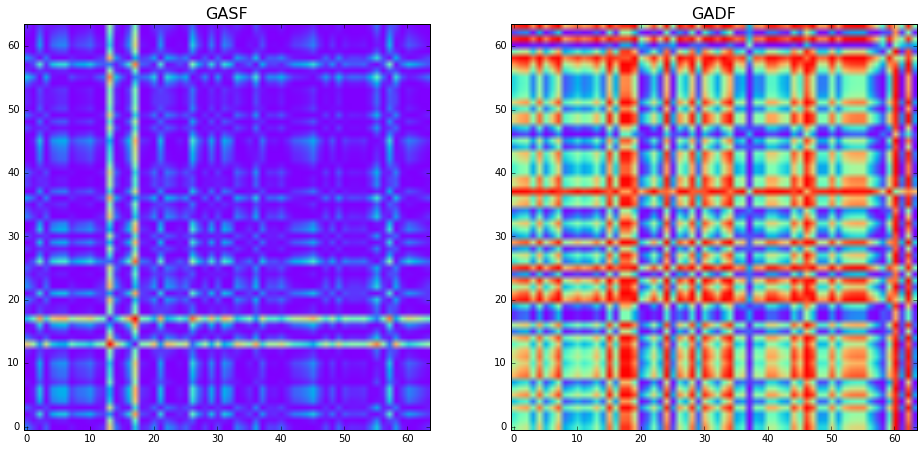

In [2]:


# Parameters
n_samples, n_features = 100, 144

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, 64)

# GAF transformations
image_size = 64
print (X.shape)
gasf = GASF(image_size)
X_gasf = gasf.fit_transform(X)
gadf = GADF(image_size)
X_gadf = gadf.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X_gasf[1], cmap='rainbow', origin='lower')
plt.title("GASF", fontsize=16)
plt.subplot(122)
plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
plt.title("GADF", fontsize=16)
plt.show()

In [3]:
stockFileNames=os.listdir('./Stocks/')

In [4]:
stockSymbol=[]
col_names=['Date','Open','High','Low','Close','Volume','c']
dataList=list()
for f in stockFileNames:
    symbol=[str.upper(f.split('.')[0])]
    fileName='./Stocks/'+f
    fp=open(fileName,'r')
    if len(fp.read())>0:
        data=np.array(pd.read_csv(fileName,header=None))
        for d in data[1:]:
            dataList.append(d)
            stockSymbol.append(symbol)
        
    fp.close()
print('DONE!!')

DONE!!


In [5]:
np.shape(dataList),np.shape(stockSymbol)

((14887665, 7), (14887665, 1))

In [6]:
df1=pd.DataFrame(dataList,columns=col_names)
df2=pd.DataFrame(stockSymbol,columns=['SYMBOL'])

In [7]:
AllSymbolList=np.unique(df2)
df=pd.concat([df1,df2],axis=1)
df.head(5)
df['Date'][:10]

0    2017-01-03
1    2017-01-04
2    2017-01-05
3    2017-01-06
4    2017-01-09
5    2017-01-10
6    2017-01-11
7    2017-01-12
8    2017-01-13
9    2017-01-17
Name: Date, dtype: object

In [8]:
allCloseDF=df[['Date','Close','SYMBOL']]
allCloseDF.head(5)

,Date,Close,SYMBOL
0,2017-01-03,24.692,OUSM
1,2017-01-04,25.026,OUSM
2,2017-01-05,24.849,OUSM
3,2017-01-06,24.781,OUSM
4,2017-01-09,24.572,OUSM


In [9]:
def getCloseDataFromSymbols(df,symbol_list):
    return df[df['SYMBOL'].isin(symbol_list)][['Date','Close']]

resultDF=getCloseDataFromSymbols(allCloseDF,['AMZN','FB','GOOGL','NFLX'])
len(resultDF)

13068

In [10]:
AllSymbolList=np.unique(df2)
df=pd.concat([df1,df2],axis=1)
df.head(5)

,Date,Open,High,Low,Close,Volume,c,SYMBOL
0,2017-01-03,24.88,24.88,24.568,24.692,12957,0,OUSM
1,2017-01-04,24.732,25.944,24.732,25.026,10840,0,OUSM
2,2017-01-05,25.874,25.874,24.8,24.849,13104,0,OUSM
3,2017-01-06,24.82,24.858,24.771,24.781,2069,0,OUSM
4,2017-01-09,24.79,24.79,24.572,24.572,17870,0,OUSM


In [11]:
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
scaler = MinMaxScaler(feature_range=(0, 1))

def getPastSequenceData(df,window):
    #df=np.array(df)
    X=[]
    y=[]
    p = scaler.fit_transform(np.array(df[:,1]).reshape(-1,1)) 
    #shuffle(p)
    for i in range(1,len(df)-window,window):
        #print(df[i-1:i+window-1],df[i+window-1])
        date=df[:,0][i]
        date=date.replace('-','')
        #print(date)
        date=np.array(date)
        vals=np.array(p[i-1:i+window-1])
        temp=vals
        X.append(temp)
        y.append(p[i+window-1])
    return X,y

In [12]:
#resultDF = scaler.fit_transform(resultDF)
print (resultDF.shape)
dataList = np.array(dataList)
temp = np.hstack((dataList[:,0:1], dataList[:,4:5]))
print (temp)
print (resultDF)
X,y=getPastSequenceData(temp,7)
X=np.array(X)

X=X.reshape(X.shape[0],X.shape[1],1)
y=np.array(y)
np.shape(X),np.shape(y)


(1866, 8)


((1866, 8, 1), (1866,))

In [86]:
tsSplit=TimeSeriesSplit(n_splits=5)
for train_index,test_index in tsSplit.split(X):
    X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = y[:len(train_index)], y[len(train_index): (len(train_index)+len(test_index))]
print(X_train.shape)

(1555, 8, 1)


In [87]:
def TimeSeriesToImage(Predictions,imageSize = 64):
    print (Predictions.shape)
    gasf = GASF(imageSize)
    X_gasf = gasf.fit_transform(Predictions)
    gadf = GADF(imageSize)
    X_gadf = gadf.fit_transform(Predictions)
    # Show the results for the first time series
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
    plt.title("GASF", fontsize=16)
    plt.subplot(122)
    plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
    plt.title("GADF", fontsize=16)
    plt.show()
    return X_gadf

(1555, 8)
(1555, 8)


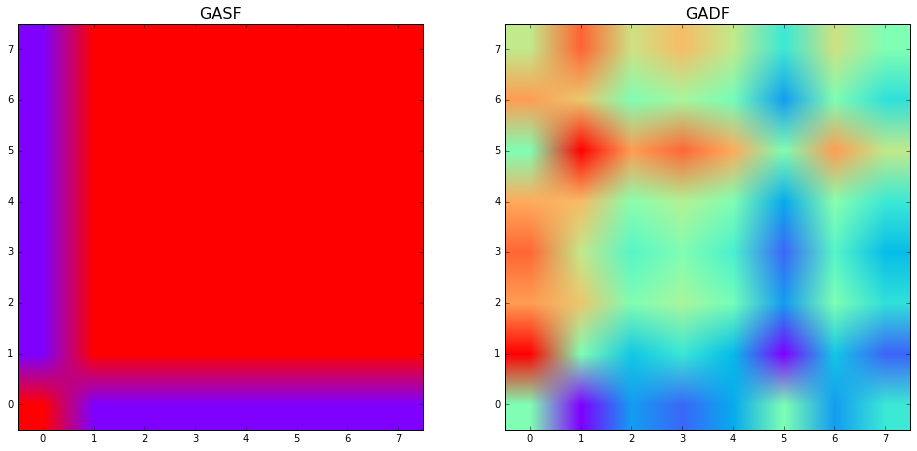

(311, 8)


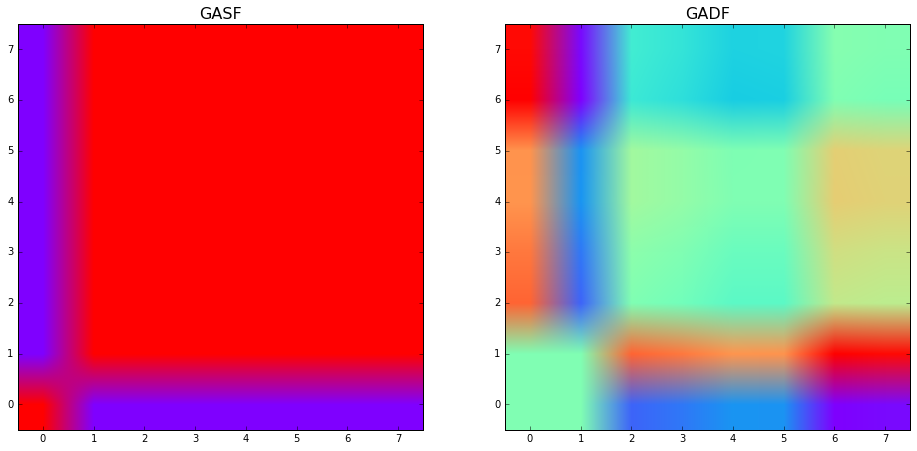

(1555, 8, 8)
(311, 8, 8)
(1555, 8, 8, 1)
(311, 8, 8, 1)


In [88]:
print (np.repeat(y_train, 8, axis=0).reshape(y_train.shape[0], 8).shape)
X_train = TimeSeriesToImage(np.squeeze(X_train), X_train.shape[1])
X_test = TimeSeriesToImage(np.squeeze(X_test), X_test.shape[1])

#Y_train = TimeSeriesToImage(np.repeat(y_train, 8, axis=0).reshape(y_train.shape[0], 8), 8)
#Y_test = TimeSeriesToImage(np.repeat(y_test, 8, axis=0).reshape(y_test.shape[0], 8), 8)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

In [94]:
# input image dimensions
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
TIME_RANGE = 20
PRICE_RANGE = 20
# add fake depth channel 
X_train_mod = X_train.reshape(X_train.shape[0],img_rows, img_cols, 1)
X_test_mod = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
Y_train = Y_train.reshape(Y_train.shape[0],img_rows, img_cols, 1)
Y_test = Y_test.reshape(Y_test.shape[0], img_rows, img_cols, 1)
input_shape = (TIME_RANGE, PRICE_RANGE, 1)

X_train_mod = X_train_mod.astype('float32')
#X_valid = X_valid.astype('float32')

print('x_train_mod shape:', X_train_mod.shape)
#print('x_valid shape:', x_valid.shape)
 
#y_train_mod = keras.utils.to_categorical(y_train, 1)
#y_valid_mod = keras.utils.to_categorical(y_valid, num_classes)

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X_train_mod.shape[1:], activation='relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile model
model.compile(loss='mse', optimizer='adam')
model.summary()




('x_train_mod shape:', (1555, 8, 8, 1))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 8, 8, 64)          640       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 

In [96]:
print(Y_train.shape)
print (X_train_mod.shape)
model.fit(X_train_mod, y_train,
          batch_size=32,
          epochs=200,
          verbose=1,
          validation_data=(X_train_mod, y_train))
 

score = model.evaluate(X_train_mod, y_train, verbose=0)



(1555, 8, 8, 1)
(1555, 8, 8, 1)
Train on 1555 samples, validate on 1555 samples
Epoch 1/200
1555/1555 [==============================] - 0s 146us/step - loss: 32959.4630 - val_loss: 33073.2864
Epoch 2/200
1555/1555 [==============================] - 0s 126us/step - loss: 33081.8590 - val_loss: 32897.2914
Epoch 3/200
1555/1555 [==============================] - 0s 133us/step - loss: 33480.2728 - val_loss: 32966.4727

In [51]:
print(score)

15592.565579782959
